**GRAPE LEAF DISEASE PREDICTION**


# **IMPORT** **REQUIRED** **LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,Conv2D, GlobalAvgPool2D, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, GlobalAveragePooling2D, UpSampling2D, Input, LeakyReLU
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import callbacks, optimizers
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications.vgg16 import preprocess_input
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

# **DATASET**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
disease_types = ['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Black_rot',
 'Grape___healthy',
 'Grape___Esca_(Black_Measles)']
data_dir = '/content/drive/MyDrive/Finalyearproject/grape_dataset'
train_dir = '/content/drive/MyDrive/Finalyearproject/grape_dataset/train'

In [ ]:
train_path = '/content/drive/MyDrive/Finalyearproject/grape_dataset/train'
test_path = '/content/drive/MyDrive/Finalyearproject/grape_dataset/test'

In [ ]:
train_path

'/content/drive/MyDrive/Finalyearproject/grape_dataset/train'

In [ ]:
for i in os.listdir(train_path):
    print(i,len(os.listdir(train_path + "/" + i)))

Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 1722
Grape___Black_rot 1888
Grape___healthy 1692
Grape___Esca_(Black_Measles) 1920


In [ ]:
class_lst = os.listdir(train_path)
batch = 24
target_size = (224,224)

In [ ]:
class_lst

['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Black_rot',
 'Grape___healthy',
 'Grape___Esca_(Black_Measles)']

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
7217,Grape___Esca_(Black_Measles)/61c5b74b-2e4d-40b...,3,Grape___Esca_(Black_Measles)
7218,Grape___Esca_(Black_Measles)/78a1df6a-ff1b-4c2...,3,Grape___Esca_(Black_Measles)
7219,Grape___Esca_(Black_Measles)/587ab471-2fa6-41d...,3,Grape___Esca_(Black_Measles)
7220,Grape___Esca_(Black_Measles)/069123c0-8f04-499...,3,Grape___Esca_(Black_Measles)
7221,Grape___Esca_(Black_Measles)/353723ef-2ce8-45a...,3,Grape___Esca_(Black_Measles)


In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Grape___Esca_(Black_Measles)/c708630b-a1a6-40a...,3,Grape___Esca_(Black_Measles)
1,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/9c1...,0,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
2,Grape___healthy/cdecb518-57f1-45f1-bfd6-bf9769...,2,Grape___healthy
3,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/f63...,0,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
4,Grape___Black_rot/38c1021c-5941-4106-88f0-973d...,1,Grape___Black_rot


In [ ]:
missing_values = train.isnull().sum()

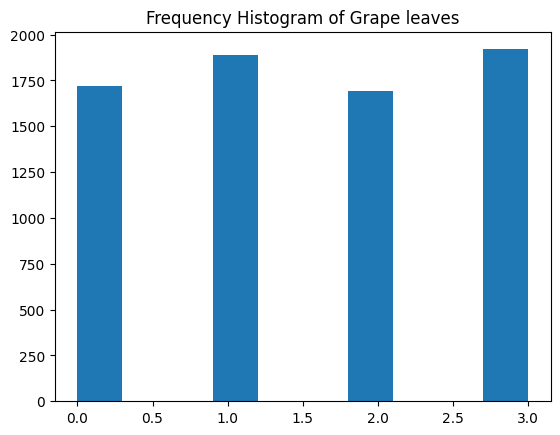

<Figure size 1200x1200 with 0 Axes>

In [ ]:
# Plot a histogram
%matplotlib inline

plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Grape leaves')
plt.figure(figsize=(12, 12))
plt.show()

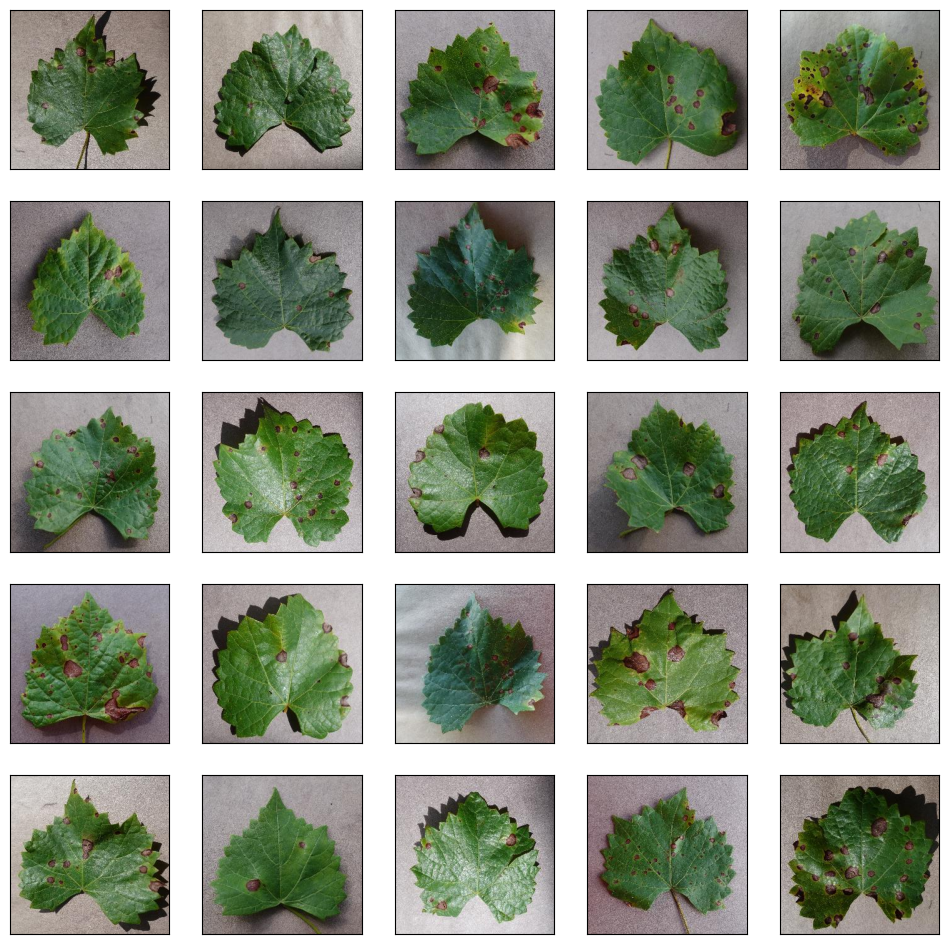

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(train_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

            # Load image using cv2
            img = cv2.imread(image_path)

            # Check if image loading was successful
            if img is not None:
                # Convert BGR to RGB if necessary
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Display the image
                ax[i, j].imshow(img)
            else:
                # Print a message if there's an issue loading the image
                print(f"Error loading image: {image_path}")

            n += 1

# Example usage
train_dir = '/content/drive/MyDrive/Finalyearproject/grape_dataset/train'
plot_defects('Grape___Black_rot', 5, 5)

# Show the plot
plt.show()


In [ ]:
gen_object = ImageDataGenerator(preprocessing_function = preprocess_input)
train_datagen = gen_object.flow_from_directory(train_path,
                                               target_size = (224,224),
                                               batch_size = 24,
                                               class_mode = 'sparse',
                                               classes = class_lst,
                                               shuffle = True

)

Found 7222 images belonging to 4 classes.


In [ ]:
test_datagen = gen_object.flow_from_directory(test_path,
                                             target_size=(224,224),
                                             batch_size=24,
                                             class_mode='sparse',
                                              classes = class_lst,
                                             shuffle=True
                                             )

Found 1805 images belonging to 4 classes.


# **MOBILENETV2** **MODEL**

In [ ]:
base_model= tf.keras.applications.MobileNetV2(
            input_shape=(224,224,3),
            alpha=1.0,
            include_top=False,0....000.
            pooling=None,
            classes=1000,
            classifier_activation="softmax",

)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(GlobalAvgPool2D())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.add(Dense(1024,activation='relu'))
model.add(Dense(4,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 3,573,828
Trainable params: 1,315,844
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
elst = callbacks.EarlyStopping(monitor='val_loss',patience=5,mode = 5)
save_ck = callbacks.ModelCheckpoint('/kaggle/working/grapemdl_wt.hdf5',save_best_only=True,monitor='val_loss',mode='min')

In [ ]:
history=model.fit(train_datagen,batch_size=24,validation_data=test_datagen,callbacks=[elst,save_ck],epochs=7)

Epoch 1/7
301/301 [==============================] - 1841s 6s/step - loss: 0.4456 - accuracy: 0.8309 - val_loss: 0.4083 - val_accuracy: 0.8260
Epoch 2/7
301/301 [==============================] - 522s 2s/step - loss: 0.2422 - accuracy: 0.8980 - val_loss: 0.2803 - val_accuracy: 0.8731
Epoch 3/7
301/301 [==============================] - 487s 2s/step - loss: 0.2060 - accuracy: 0.9130 - val_loss: 0.2302 - val_accuracy: 0.9058
Epoch 4/7
301/301 [==============================] - 505s 2s/step - loss: 0.1783 - accuracy: 0.9229 - val_loss: 0.2664 - val_accuracy: 0.9019
Epoch 5/7
301/301 [==============================] - 507s 2s/step - loss: 0.1655 - accuracy: 0.9297 - val_loss: 0.2193 - val_accuracy: 0.9108
Epoch 6/7
301/301 [==============================] - 517s 2s/step - loss: 0.1461 - accuracy: 0.9366 - val_loss: 0.2193 - val_accuracy: 0.9075
Epoch 7/7
301/301 [==============================] - 495s 2s/step - loss: 0.1216 - accuracy: 0.9503 - val_loss: 0.2539 - val_accuracy: 0.9136


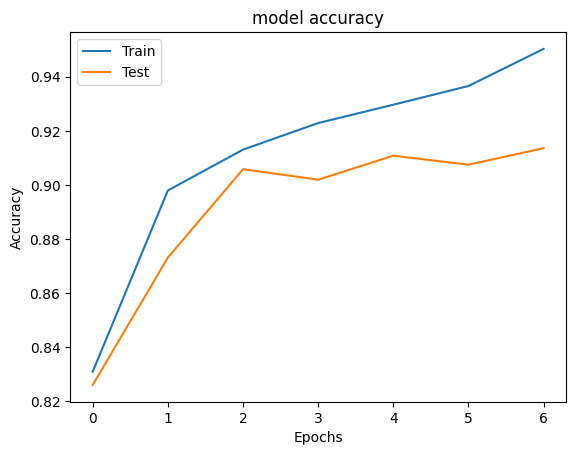

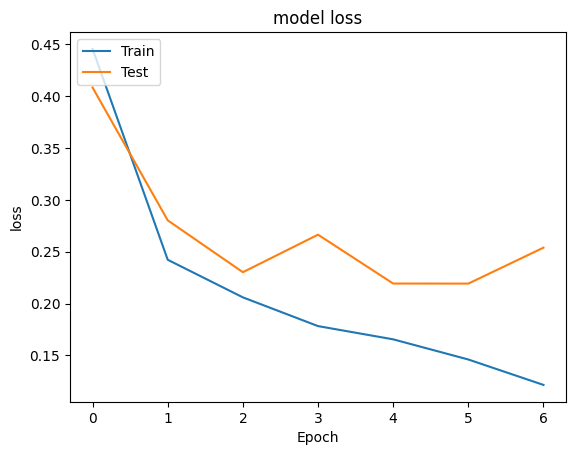

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
history.history

{'loss': [0.44555315375328064,
  0.2422492951154709,
  0.20599721372127533,
  0.17827877402305603,
  0.16551761329174042,
  0.14607110619544983,
  0.12155909091234207],
 'accuracy': [0.8309332728385925,
  0.8979507088661194,
  0.9130434989929199,
  0.9228745698928833,
  0.929659366607666,
  0.9365826845169067,
  0.9502907991409302],
 'val_loss': [0.4083108901977539,
  0.28026655316352844,
  0.2302459329366684,
  0.2664341330528259,
  0.21931679546833038,
  0.21926090121269226,
  0.2539163827896118],
 'val_accuracy': [0.8260387778282166,
  0.873130202293396,
  0.9058171510696411,
  0.9019390344619751,
  0.9108033180236816,
  0.9074792265892029,
  0.9135733842849731]}

In [ ]:
acc=model.evaluate(train_datagen, verbose=1, steps=24, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
msg

24/24 [==============================] - 28s 1s/step - loss: 0.1093 - accuracy: 0.9531


'accuracy on the test set is 95.31 %'

In [ ]:
predictions = model.predict(test_datagen)

76/76 [==============================] - 89s 1s/step


In [ ]:
rounded_prediction = np.argmax(predictions, axis = -1)

In [ ]:
cm = confusion_matrix(test_datagen.classes,y_pred =rounded_prediction)
cm

array([[118,  94,  81, 137],
       [110, 103, 123, 136],
       [101,  86, 107, 129],
       [118, 102, 107, 153]])

<Axes: >

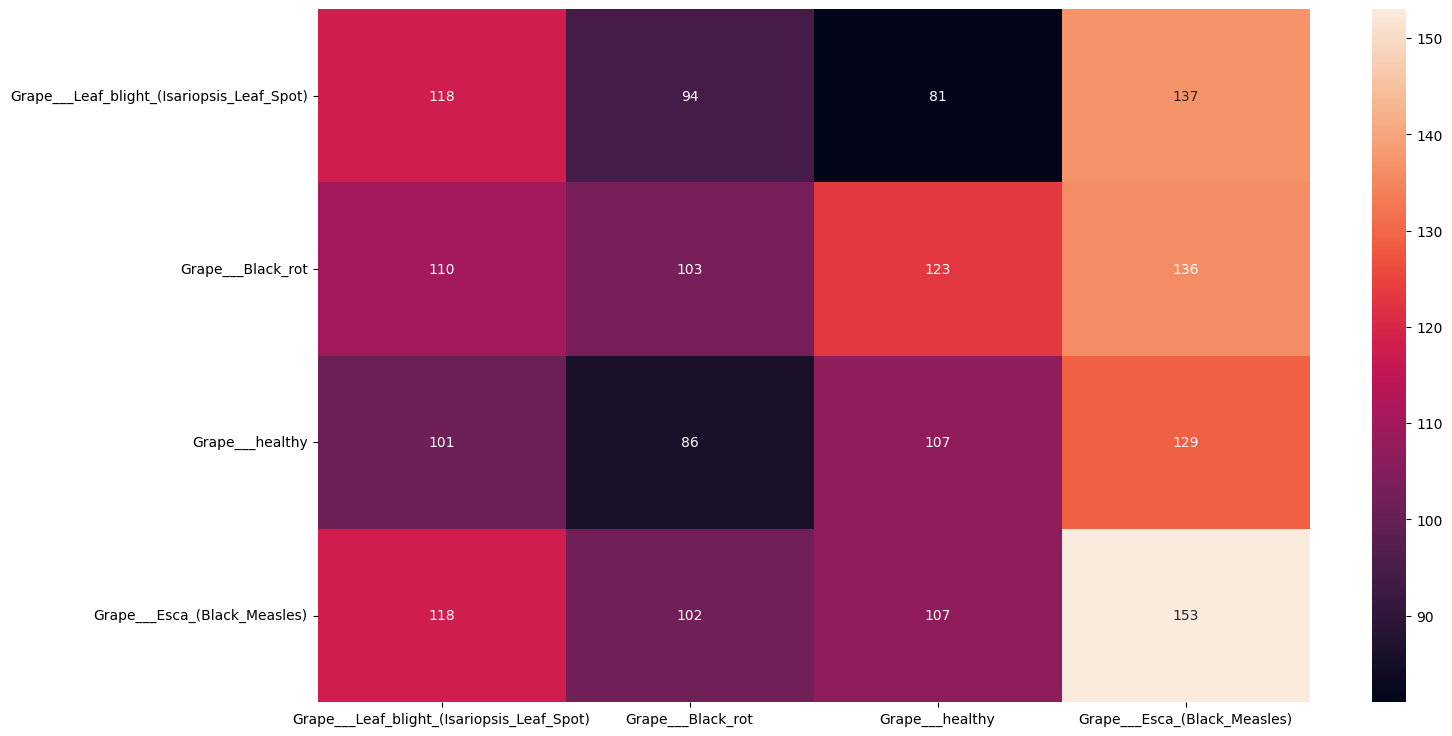

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_lst,yticklabels=class_lst)

1/1 [==============================] - 1s 937ms/step
[5.0209793e-03 8.1629920e-01 1.7863278e-01 4.6988858e-05]


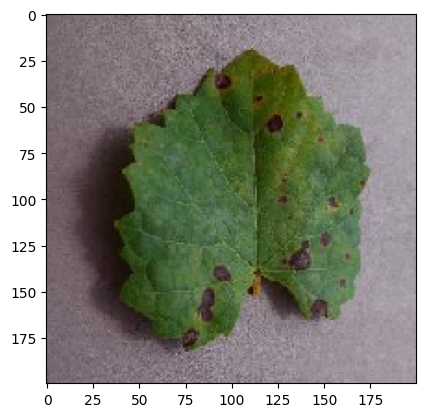

Prediction: Grape___Black_rot


In [ ]:
# Load the image with the target size
img_path = '/content/drive/MyDrive/Finalyearproject/grape_dataset/test/Grape___Black_rot/00090b0f-c140-4e77-8d20-d39f67b75fcc___FAM_B.Rot 0376.JPG'
img = load_img(img_path, target_size=(224, 224))
show_img = load_img(img_path, target_size=(200, 200))

# Convert the image to a numpy array
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)  # Assuming you are using a pre-trained model that requires preprocessing

# Make a prediction
custom = model.predict(x)
print(custom[0])

# Display the image
plt.imshow(show_img)
plt.show()

# Get the predicted class
predicted_class_index = np.argmax(custom[0])
predicted_class = disease_types[predicted_class_index]
print('Prediction:', predicted_class)


In [ ]:
model.save('grape_disease.h5')

# **RESNET50** **MODEL**

In [ ]:
resnet = tf.keras.applications.ResNet50(input_shape=(227,227,3), include_top=False, weights='imagenet', classes=5)

x = GlobalAvgPool2D()(resnet.output)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(units=5,activation = 'softmax')(x)
model_resnet = Model(resnet.input, output)
model_resnet.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 233, 233, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 114, 114, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Compile the model
model_resnet.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Train the model (you may have already done this before evaluating accuracy)
hist =model_resnet.fit(train_datagen,batch_size=24,validation_data=test_datagen,callbacks=[elst,save_ck],epochs=3)

# Evaluate the model on the test data.
accuracy=model.evaluate( test_datagen, verbose=1, steps=24, return_dict=False)[1]*100
print(f'Test Accuracy:  {accuracy:5.2f} %')


24/24 [==============================] - 30s 1s/step - loss: 0.3147 - accuracy: 0.8941
Test Accuracy:  89.41 %


# REAL TIME VIDEO PREDICTION

In [2]:
# import dependencies
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [3]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [4]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [5]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [6]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [7]:
pip install opencv-python Pillow


In [8]:
def get_class_name(class_index):
    # You need to define a mapping of class indices to disease names based on your model
    # Replace the following with your actual class names
    class_names = {
        0: "Leaf_blight",
        1: "Black_rot",
        2: "Healthy",
        3: "Grape_Esca",
    }
    return class_names.get(class_index, "Unknown Disease")

# PREDICTION

In [13]:
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
from base64 import b64decode, b64encode
import IPython.display
import ipywidgets as widgets
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from google.colab import drive

drive.mount('/content/drive')

# Load your disease prediction model
model = load_model('/content/drive/MyDrive/Finalyearproject/grape_disease (1).h5')

#model = load_model('/content/grape_disease.h5')


# Load the face cascade for face detection
#face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def js_to_image(js_reply):
    """
    Convert JavaScript image to OpenCV image
    """
    image_bytes = b64decode(js_reply.split(',')[1])
    img_buf = BytesIO(image_bytes)
    return Image.open(img_buf)

def bbox_to_bytes(bbox_array):
    """
    Convert bounding box array to bytes
    """
    bbox_pil = Image.fromarray(bbox_array)
    iobuf = BytesIO()
    bbox_pil.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

def predict_disease(img):
    """
    Perform disease prediction on the given image
    """
    # Preprocess the image
    img = img.resize((224, 224))  # Assuming your model expects 224x224 images
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions
    predictions = model.predict(img_array)
    return predictions

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialize bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if _ is True:
        a = np.argmax(model.predict(np.array([cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),(32,32))])))
        a = get_class_name(a)
        frame = cv2.putText(frame, a , (25,25), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (0,225,0), 2, cv2.LINE_AA)

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # grayscale image for face detection
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)


    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)

    # get face bounding box for overlay
    for (x, y, w, h) in faces:
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Crop the detected face region for disease prediction
        face_img = img.crop((x, y, x + w, y + h))

        # Perform disease prediction
        predictions = predict_disease(face_img)

        # Display predictions on the bounding box
        label = f'Disease: {get_class_name(np.argmax(predictions))}'  # Assuming prediction is class index
        cv2.putText(bbox_array, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so the next frame gets a new overlay
    bbox = bbox_bytes




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 66ms/step


TypeError: string indices must be integers

# DETECT


In [14]:
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
from base64 import b64decode, b64encode
import IPython.display
import ipywidgets as widgets
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from google.colab import drive

drive.mount('/content/drive')

# Load your disease prediction model
model = load_model('/content/drive/MyDrive/Finalyearproject/grape_disease (1).h5')

# Load the face cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def js_to_image(js_reply):
    """
    Convert JavaScript image to OpenCV image
    """
    image_bytes = b64decode(js_reply.split(',')[1])
    img_buf = BytesIO(image_bytes)
    return Image.open(img_buf)

def bbox_to_bytes(bbox_array):
    """
    Convert bounding box array to bytes
    """
    bbox_pil = Image.fromarray(bbox_array)
    iobuf = BytesIO()
    bbox_pil.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

def predict_disease(img):
    """
    Perform disease prediction on the given image
    """
    # Preprocess the image
    img = img.resize((224, 224))  # Assuming your model expects 224x224 images
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions
    predictions = model.predict(img_array)
    return predictions

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialize bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if _ is True:
        a = np.argmax(model.predict(np.array([cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),(32,32))])))
        a = get_class_name(a)
        frame = cv2.putText(frame, a , (25,25), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (0,225,0), 2, cv2.LINE_AA)

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # get face bounding box for overlay
    if len(faces) > 0:
        largest_face_idx = np.argmax([w * h for (x, y, w, h) in faces])
        (x, y, w, h) = faces[largest_face_idx]

        bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Crop the detected face region for disease prediction
        face_img = img.crop((x, y, x + w, y + h))

        # Perform disease prediction
        predictions = predict_disease(face_img)

        # Display predictions on the bounding box if confidence is above the threshold
        confidence_threshold = 0.8
        max_prediction_idx = np.argmax(predictions)
        max_prediction_confidence = predictions[0, max_prediction_idx]

        if max_prediction_confidence > confidence_threshold:
            label = f'Disease: {get_class_name(max_prediction_idx)}'
            cv2.putText(bbox_array, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so the next frame gets a new overlay
    bbox = bbox_bytes


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 63ms/step


TypeError: string indices must be integers